In [186]:
import torch 
import torch.nn.functional as F
import seaborn as sns
from circuitsvis.attention import attention_heads, attention_patterns
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import os

In [152]:
# Global settings
torch.set_grad_enabled(False) #to disable gradients -> faster computiations
model = None
tokenizer = None
META_LLAMA_3_2_3B = "meta-llama/Llama-3.2-3B"
GOOGLE_GEMMA_2_2B = "google/gemma-2-2b"
dataset = {}

In [191]:
def load_dataset(path_to_csv: str):
    # Check if the file at the given path exists
    if os.path.exists(path_to_csv):
        df = pd.read_csv(path_to_csv)
    else:
        print("File does not exist.")
        exit(1)

    global dataset 
    dataset = df
    
            

In [166]:
def print_colored_separator(color="\033[94m", char="=", length=150):
    reset = "\033[0m"  # Reset color
    print(f"{color}{char * length}{reset}")

In [176]:
# Returns the model's output after feeding it with a prompt concatenated prompt_repetitions times and the concatenated prompt tensor
def feed_forward(prompt: str, prompt_repetitions: int = 1):
    print_colored_separator()
    print(f"Input: {prompt}\n")
    token_sequence = tokenizer(prompt, return_tensors="pt")
    tokens = token_sequence["input_ids"][0]
    print(f"Tokenizer tokens: {tokens}\n")
    
    sentence_to_concatenate = tokens
    for _ in range(prompt_repetitions):
        sentence_to_concatenate = torch.concat([sentence_to_concatenate, tokens[1:]])

    print("Concatenated prompt:")
    print(f"{tokenizer.decode(sentence_to_concatenate)}\n")
    print("Concatenated tokens:")
    print(f"{sentence_to_concatenate}\n")

    # Feed forward to the model
    global model
    out = model(sentence_to_concatenate.unsqueeze(0), return_dict=True, output_attentions=True)
    return out, sentence_to_concatenate

In [171]:
def create_attention_mask(token_sequence: str):
    print_colored_separator()
    sequence_length = len(token_sequence)
    half_of_sequence = sequence_length // 2 - 1
    induction_mask = torch.zeros(sequence_length, sequence_length).to(float)

    for i in range(sequence_length // 2 + 1, sequence_length):
        induction_mask[i, i - half_of_sequence] = 1 
    
    print("Induction Mask:\n")
    print(induction_mask)
    print()
    print("Induction Mask plot:\n")
    plt.imshow(induction_mask)
    plt.show()
    print()
    return induction_mask

In [216]:
def compute_induction_head_scores(token_sequence: str, induction_mask: torch.Tensor, model_output):
    num_heads = model.config.num_attention_heads
    num_layers = model.config.num_hidden_layers
    sequence_length = len(token_sequence)

    induction_scores = torch.zeros(num_layers, num_heads)
    tril = torch.tril_indices(sequence_length - 1, sequence_length - 1) # gets the indices of elements on and below the diagonal
    induction_flat = induction_mask[tril[0], tril[1]].flatten()
    
    for layer in range(num_layers):
        for head in range(num_heads):
            pattern = model_output["attentions"][layer][0][head].cpu().to(float)[1:, 1:]
            pattern_flat = pattern[tril[0], tril[1]].flatten()
            score = (induction_flat @ pattern_flat) / pattern_flat.sum()
            induction_scores[layer, head] = score
    return induction_scores

In [215]:
def create_heatmap(induction_scores: torch.Tensor):
    print_colored_separator()
    _, ax = plt.subplots()
    print("Heatmap of induction scores across heads and layers: \n")
    sns.heatmap(induction_scores, cbar_kws={"label": "Induction Head Score"}, ax=ax)
    ax.set_ylabel("Layer #")
    ax.set_xlabel("Head #")
    plt.show()

In [214]:
def sort_high_scoring_heads(induction_scores: torch.Tensor, model_output: any): 
    print_colored_separator()
    # Get flattened indices sorted by scores in descending order
    sorted_flat_indices = torch.argsort(induction_scores.flatten(), descending=True)

    # Convert flattened indices to 2D indices
    sorted_indices = torch.unravel_index(sorted_flat_indices, induction_scores.shape)
    # Stack the row and column indices for final output
    sorted_indices = torch.stack(sorted_indices, dim=1)

    print("Top 5 Induction Heads with the highest induction score - Descending order\n")
    for layer, head in sorted_indices[:5]:
        print(f"Layer: {layer}\nHead: {head}")
        plt.imshow(model_output["attentions"][layer][0][head].cpu().float())
        plt.show()
        print()
    return sorted_indices

In [218]:
def token_probability_extraction(head_indices: torch.Tensor, models_output: any):
    top_layer, top_head = head_indices[0]
    probs = models_output["attentions"][top_layer][0][top_head]

    # Extract probability of the specified token
    sequence_length = probs.shape[0]
    probability_token = probs[sequence_length - 2, sequence_length // 2].item() * 100

    print_colored_separator()
    print("Probability of token: ", probability_token)
    return probability_token


In [ ]:
def log_probability(probability_token: int, prompt: str):
    if dataset.empty:
        raise Exception("Dataset is empty")
    
    

In [212]:
def display_attention_visualizations(head_indices: torch.Tensor, token_sequence: torch.Tensor, models_output):
    # Display attention diagrams
    tokens_vis = tokenizer.tokenize(tokenizer.decode(token_sequence.squeeze()))
    layer, head = head_indices[0]
    return attention_patterns(tokens_vis, models_output["attentions"][layer][0]), attention_heads(models_output["attentions"][layer][0], tokens_vis)

In [211]:
def initialize_model(model_name: str, tokenizer_name: str = None):
    if not tokenizer_name:
        tokenizer_name = model_name
    # Initialize model and tokenizer
    global model
    model = AutoModelForCausalLM.from_pretrained(model_name)
    if not tokenizer_name:
        tokenizer_name = model_name
    global tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)


In [210]:
def run_experiment(prompt: str, prompt_repetitions: int = 1):
    models_output, token_sequence = feed_forward(prompt=prompt, prompt_repetitions=prompt_repetitions)
    induction_mask = create_attention_mask(token_sequence=token_sequence)
    induction_scores = compute_induction_head_scores(token_sequence=token_sequence, induction_mask=induction_mask, model_output=models_output)
    # create_heatmap(induction_scores=induction_scores)
    high_scoring_heads_indices_sorted = sort_high_scoring_heads(induction_scores=induction_scores, model_output=models_output)

    token_probability_extraction(high_scoring_heads_indices_sorted, models_output)

    # Visualize attention 
    attention_patterns_view, attention_head_view = display_attention_visualizations(head_indices=high_scoring_heads_indices_sorted, token_sequence=token_sequence, models_output=models_output)
    return attention_patterns_view, attention_head_view

In [ ]:
initialize_model(model_name=META_LLAMA_3_2_3B, tokenizer_name=META_LLAMA_3_2_3B)

Input: The planet earth is round

Tokenizer tokens: tensor([128000,    791,  11841,   9578,    374,   4883])

Concatenated prompt:
<|begin_of_text|>The planet earth is roundThe planet earth is round

Concatenated tokens:
tensor([128000,    791,  11841,   9578,    374,   4883,    791,  11841,   9578,
           374,   4883])

Induction Mask:

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=torch.float64)

Induction Mask plot:



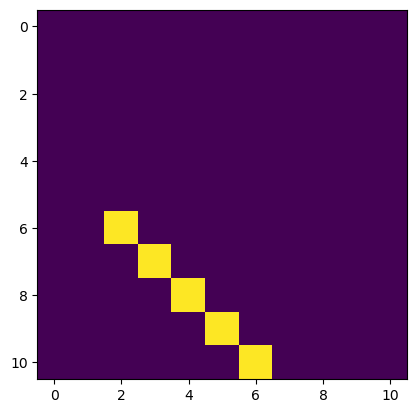


Top 5 Induction Heads with the highest induction score - Descending order

Layer: 2
Head: 16


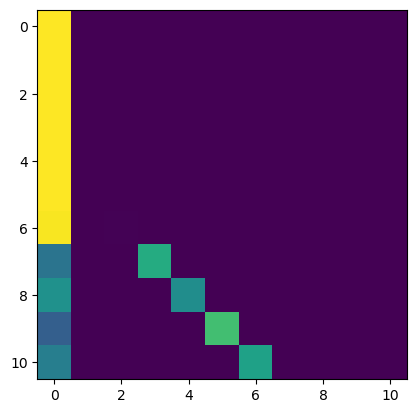


Layer: 2
Head: 15


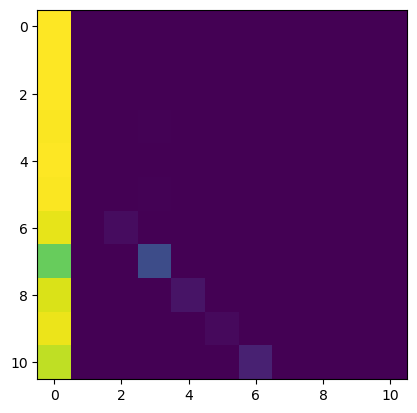


Layer: 14
Head: 22


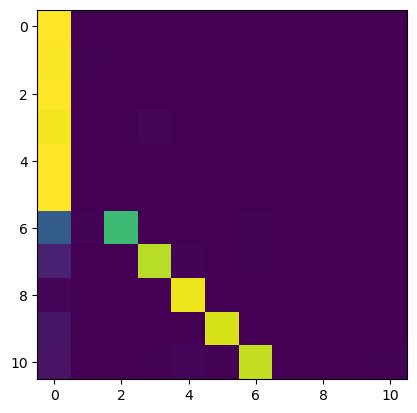


Layer: 2
Head: 19


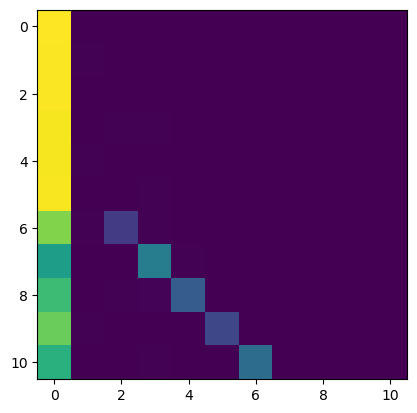


Layer: 5
Head: 6


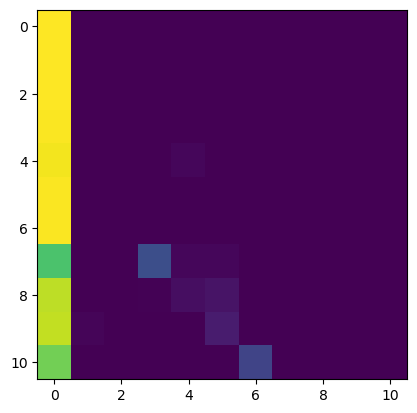


tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9910e-01, 9.0419e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9957e-01, 1.1675e-04, 3.1008e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9812e-01, 7.6594e-05, 1.1955e-04, 1.6858e-03, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9861e-01, 9.5594e-05, 4.0827e-06, 1.3190e-04, 1.1586e-03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9979e-01, 2.1328e-05, 4.0154e-06, 1.7705e-04, 9.0678e-06, 3.2249e-06,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.9214e-01, 1.4537e-03, 5.2569e-03, 4.9526e-05, 9.1504e-04, 1.2686e-05,
         1.7

In [219]:
attention_patterns_view, attention_heads_view = run_experiment(prompt="The planet earth is round", prompt_repetitions=1)
attention_patterns_view
attention_heads_view